<a href="https://colab.research.google.com/github/saranpan/ECG-Heartbeat-classifier/blob/main/mi_classification/Myocardial_train_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Hardware will be used on this notebook

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-98533401-ca0b-ecf0-2601-7f3c57b9f287)


# 🌏 Business Understanding 



The healthcare industry is experiencing significant growth with the integration of advanced technologies to improve patient outcomes and ease the burden on doctors. One of the most important technologies is the electrocardiogram (ECG), which can accurately check the electrical activity and rhythm of the heart. Early detection and diagnosis of myocardial infarction (MI)  (กล้ามเนื้อหัวใจตาย) is crucial to prevent life-threatening complications.

Myocardial infarction occurs when there is a sudden interruption of blood supply to the heart, which can cause serious damage to the heart muscle. Identifying patients with MI requires timely and accurate diagnosis, which can be challenging for doctors.

To overcome this challenge, we aim to develop a product that uses AI to classify ECG signals as either indicative of MI or not. The goal is to accurately identify patients with MI and provide appropriate treatment. Our model will be trained on a labeled dataset of ECG signals and corresponding MI classifications, and the performance of the model will be evaluated using relevant metrics such as weighted F1 score.

In summary, our goal is to develop an AI-based solution that can accurately classify ECG signals to determine the presence of MI. This will aid in timely and accurate diagnosis, resulting in improved patient outcomes.

# 📰 Data Understanding

The dataset for this project consists of ECG heartbeat signals, which will be used as input to train the machine learning model. The dataset includes labeled data, with each ECG heartbeat signal corresponding to either the presence of myocardial infarction (MI) or not. This task is a binary classification problem, where the model will predict whether a patient has MI or not.

The objective of this project is to develop a machine learning approach that accurately classifies ECG signals as indicative of MI or not, which can aid in the early detection and diagnosis of MI. The labeled dataset of ECG signals and corresponding MI classifications will be used to train the machine learning model. The model's performance will be evaluated using the binary F1 score as the criterion for selecting the best model.

In summary, the data understanding phase of this project involves analyzing the labeled dataset of ECG signals and corresponding MI classifications. The goal is to develop a machine learning model that accurately classifies ECG signals as indicative of MI or not, which can aid in the early detection and diagnosis of MI. The binary F1 score will be used to evaluate the model's performance.


To develop a machine learning model for ECG analysis, we needed to collect a dataset with ECG heartbeat signals as predictors and binary labels indicating the presence or absence of Myocardial Infarction as the target. One such dataset we found on [Kaggle](https://www.kaggle.com/datasets/shayanfazeli/heartbeat) was scraped from a [research paper](https://arxiv.org/abs/1805.00794) , which in turn was scraped from the [PTB Diagnostic ECG Database](https://www.physionet.org/content/ptbdb/1.0.0/). However, the dataset was downsampled, resulting in a reduced number of rows. It is important to note that the trained model cannot be applied universally as it has limitations arising from the dataset used to train it. Therefore, it is worth reviewing some metadata of the PTB Diagnostic ECG Database, which we used to train the model.

The summary of the limitations of this dataset are as follows:

> Small sample size: The dataset has only 549 records from 290 subjects, which may not be representative of the general population.

> Imbalanced classes: The dataset is imbalanced, with the majority of records being from patients with Myocardial Infarction, which may affect the performance of machine learning algorithms in detecting other heart conditions.

> Limited clinical information: Although the dataset includes a detailed clinical summary for most records, it is not available for 22 subjects. Additionally, the dataset does not include information on the severity of the heart conditions or other factors that may impact the diagnosis.

> Limited recording conditions: The ECG recordings were obtained using a non-commercial, PTB prototype recorder with specific specifications, which may not be representative of other recording conditions. Additionally, the dataset only includes recordings at a sampling rate of 1000 samples per second, which may not capture all relevant information in the ECG signal.

> Limited diversity: The dataset was collected from patients in Berlin, Germany, and may not be representative of other populations or geographic regions. Additionally, the dataset has a majority of male participants, which may impact the generalizability of the results to female populations.

Although the PTB Diagnostic ECG Database is a valuable resource for ECG analysis research and algorithmic benchmarking, the limitations of the dataset must be considered when interpreting the results.

Moreover, it is essential to understand the limitations of the model's inference. For instance, the model may not accurately diagnose heart conditions for patients in 2023 as the dataset used to train the model may not include recent cases of heart conditions and may not be representative of the current population. Additionally, the model's performance may be affected by factors such as the quality of the ECG signal, variations in recording conditions, and limitations in the algorithms used for analysis. Therefore, caution should be exercised when applying the model's results to real-world scenarios, considering both the dataset and the model's limitations.

Moreover, the data from the [PTB Diagnostic ECG Database](https://www.physionet.org/content/ptbdb/1.0.0/) is not exactly the same used for modeling in the [research paper](https://arxiv.org/abs/1805.00794), the author of paper have preprocessed in the following steps

1. Splitting the continuous ECG signal to 10s windows and select a 10s window from an ECG signal. 

2. Normalizing the amplitude values to the range of between zero and one. 

3. Finding the set of all local maximums based on zerocrossings of the first derivative. 

4. Finding the set of ECG R-peak candidates by applying a threshold of 0.9 on the normalized value of the local maximums. 

5. Finding the median of R-R time intervals as the nominal heartbeat period of that window (T). 

6. For each R-peak, selecting a signal part with the length equal to 1.2T. 

7. Padding each selected part with zeros to make its length equal to a predefined fixed length.

The size of the whole dataset is approximately 10,000 rows, That is an overview of the metadata for this dataset. Moving forward, we will import the dataset and conduct exploratory analysis to gain a more comprehensive understanding of its contents.

(The method conducting in this notebook is similar to [Arhythmia](https://colab.research.google.com/drive/1rqp2jdPIHLjDu3xOC1Clc5S9Xb5D4BtP?usp=sharing)). The only things are 

1. multi-class classification -> binary classification
2. performing threshold optimization

In [ ]:
%%capture
!pip install kora kaggle # API for import dataset from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

print('setup libraries completed')

setup libraries completed


In [ ]:
from kora import kaggle
from sklearn.model_selection import train_test_split

def import_kaggle_dataset():
    # If failed, download Kaggle API to your drive first
    kaggle.download('shayanfazeli/heartbeat')
    print('The Kaggle Dataset was downloaded into your directory')

def create_myocardial_infarction_dataset(seed=42):
    negative = pd.read_csv('/content/ptbdb_normal.csv', header=None)
    positive = pd.read_csv('/content/ptbdb_abnormal.csv', header=None)

    # split the negative and positive datasets into training and validation sets separately
    neg_train, neg_test = train_test_split(negative, test_size=0.2, random_state=seed)
    pos_train, pos_test = train_test_split(positive, test_size=0.2, random_state=seed)

    # concatenate the training and validation sets
    train = pd.concat([neg_train,pos_train])
    test = pd.concat([neg_test,pos_test])

    train.rename(columns={187: "class"}, inplace=True)
    test.rename(columns={187: "class"}, inplace=True)

    train['class'] = train['class'].astype(int)
    test['class'] = test['class'].astype(int)

    # return the training and validation sets
    return train, test

def check_null(df):
    if df.isnull().values.any():
        print("The dataset contains null values")
    else:
        print("The dataset contains NO null values")

def get_proportion_train_test(train,test):
    total = len(train) + len(test)

    train_prop = len(train) / total 
    test_prop = len(test) / total 

    return f'train:test proportion = {train_prop:.2f} : {test_prop:.2f}'

In [ ]:
import_kaggle_dataset()
#  <- Check the data files in your directory
train, test = create_myocardial_infarction_dataset()

100% 98.8M/98.8M [00:04<00:00, 24.4MB/s]
100% 98.8M/98.8M [00:04<00:00, 23.3MB/s]
The Kaggle Dataset was downloaded into your directory


In [ ]:
print( f' Arrhythmia : {get_proportion_train_test(train,test)}' )

 Arrhythmia : train:test proportion = 0.80 : 0.20


In [ ]:
# Check null
check_null(train)
check_null(test)

The dataset contains NO null values
The dataset contains NO null values


In [ ]:
# Originally, Only train and test dataset were already splitted by kaggle, 
# we need to further split train into train and val where the size is equal to test
# goal : train-test : 80-20 into train-val-test : 60-20-20
# since 25% of 80% is 20%, hence, we will split the train into train-val by 75:25

seed = 42
train, val = train_test_split(train, test_size=0.25, random_state=seed, stratify=train['class'])

In [ ]:
import plotly.graph_objects as go

def plot_class(train,val,title='Value counts for each class of ..'):
    # Create a bar plot for train and val and test set for each class
    train_value_counts = train['class'].value_counts()
    val_value_counts = val['class'].value_counts()
    test_value_counts = test['class'].value_counts()

    fig = go.Figure(go.Bar(
                x=train_value_counts.index,
                y=train_value_counts.values,
                text=train_value_counts.values,
                textposition='auto',
                name='Train Set'
            ))
    
    fig.add_trace(go.Bar(
            x=val_value_counts.index,
            y=val_value_counts.values,
            text=val_value_counts.values,
            textposition='auto',
            name='Validation Set'
        ))
    
    fig.add_trace(go.Bar(
            x=test_value_counts.index,
            y=test_value_counts.values,
            text=test_value_counts.values,
            textposition='auto',
            name='Test Set'
        ))
    
    # Set plot title and axis labels
    fig.update_layout(title=title,
                    xaxis_title="Class",
                    yaxis_title="Count")

    # Display the plot
    fig.show()

In [ ]:
plot_class(train,test, title='Value counts for each class  in train/test set of PTBDB dataset')

In [ ]:
print(f'The minority class with no Myocardial Infarction {2427 / 6303 : .2f}')

The minority class with no Myocardial Infarction  0.39


Clearly, it's an imbalanced dataset, this will lead us to be more carefully on dealing with them

In this notebook, I (Run) will use weighted binary cross-entropy over plain binary cross-entropy which treat every class with the same weight

Next, we wouldl like to observe the random heartbeat of each class of myocardial infarction

In [ ]:
import plotly.express as px

def plot_individual_class(df):

    # randomly sample one row per class
    df_sampled = df.groupby('class').apply(lambda x: x.sample(n=1)).reset_index(drop=True)


    # melt the dataframe to convert it from wide to long format
    df_melted = df_sampled.melt(id_vars='class', var_name='timestep')

    # create the line plot with Plotly
    fig = px.line(df_melted, x='timestep', y='value', color='class')

    # update the layout of the plot
    fig.update_layout(title='1-beat ECG for patient with Myocardial Infarction (1) and not (0)',
                    xaxis_title='Timestep',
                    yaxis_title='Normalized value')

    # display the plot
    fig.show()

In [ ]:
plot_individual_class(train)

# Re-run to see new random observations for each class 

Seems like this dataset was zero padded until timestep 187.

Let's check if any beat is fully completed in recording to timestep 187

In [ ]:
train[train[186] != 0]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class


In [ ]:
val[val[186] != 0]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class


In [ ]:
test[test[186] != 0]

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class


Clearly, we do not see any beats reach timestep 187, then why do they zero-padding? This is because the author of the paper aims to do transfer learning from the arhythmic which have the maximum recording at timestep 187.

Before using this dataset let's truncate into the max length for just this task and create new dataset 

In [ ]:
# Check the max length

for col in reversed(range(187)):
    train_len = len(train[train[col] != 0])
    val_len = len(val[val[col] != 0])
    test_len = len(test[test[col] != 0])

    if any([train_len, val_len, test_len]):
        print(f'last timestep of MI. dataset is {col}')
        break

last timestep of MI. dataset is 185


Certainly, the max length of MI. dataset is 186 timestep

Although, this is not significantly different much, and adding one more zero padding should not hurt performance. When we try the architecture which is not from the pretrained model of Arhythmic. We won't truncate

# 🔍 Data Preparation

Before doing anything, it's good to set deteministic seed, so, we can reproduce the result

Although, it's not possible to fully reproduce, but we can minimize the variance of the result

In [ ]:
import torch
import random
import numpy as np

# Set up reproducible seed
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

## Data augmentation

Since I'm not currently an domain expert about heartbeat signal, I'm not confident enough to do data augmentation. I think there will be many source discussed about this, we will further read in the future

In [ ]:
# Skip

## Torch Dataset

In this notebook, I (Run) decided to use Pytorch Framework, so, we need to transform train, val, test into torch dataset object

In [ ]:
# Pandas to numpy 

X_train = train.values[:, :-1] 
y_train = train.values[:, -1].astype(int)
y_train = y_train.reshape(-1, 1)

X_val = val.values[:, :-1]
y_val = val.values[:, -1].astype(int)
y_val = y_val.reshape(-1, 1)

X_test = test.values[:, :-1]
y_test = test.values[:, -1].astype(int)
y_test = y_test.reshape(-1, 1)

In [ ]:
import os
import torch
from torch.utils.data import Dataset

class MI_Dataset(Dataset):
    def __init__(self, X, y, truncate_to_max = False, transforms=None):
        """
        truncate_to_max == True : will truncate the X shape from 187 into 186
        """
        assert y.shape[1] == 1
        assert X.shape[1] == 187
        assert X.ndim == 2
                
        self.X = X
        self.y = y
        self.transforms = transforms
        self.truncate_to_max = False
        self._process()

    def _process(self):
        if self.truncate_to_max:
            self.X = self.X[:,:186]

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,index):
        
        X = torch.tensor( self.X[index] , dtype=torch.float32)
        X = X.unsqueeze(0)
        y = torch.tensor( self.y[index] , dtype = torch.float32)#.long()

        if self.transforms:
            X = self.transforms(X)

        return X, y

In [ ]:
# Setup

train_set = MI_Dataset(X_train,y_train)
val_set = MI_Dataset(X_val,y_val)
test_set = MI_Dataset(X_test,y_test)

In [ ]:
train_set[0][1]

tensor([1.])

In [ ]:
# DON"T forget threshold optimization

As well as dataloader, since we decided to do mini-batches GD. in order to overcome the out-of-memory issue in RAM. Batch_size for val_set is arbitrary, but cannot be full-batch size, otherwise, it will be out-of-memory 


Doing Mini-batch also make a set of parameter of the model converges faster, and generalize better than batch GD.

In [ ]:
from torch.utils.data import DataLoader

def get_loader(train_set,val_set,test_set,train_batch_size = 256):
    """
    Return train_loader and val_loader given wandb.config
    !Warning : Make sure to declare p_train, p_val as global variable before

    """
    # Dependence Config : architecture, batch_size, transform

    train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1024, shuffle=False) # Val set should not be fine tuned, since they always give the same score regardless the batch size
    test_loader = DataLoader(test_set, batch_size=1024, shuffle=False) # Val set should not be fine tuned, since they always give the same score regardless the batch size

    return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = get_loader(train_set,val_set,test_set,train_batch_size = 256) # Train batch_size

# 👉 Modelling

## Setup all architecture

Although sequence is not arbitrary due to zero padding, but order still need to be preserved, so we will give up on non-sequence model due to bad representation of human intelligence. Hence, all candidates we choose will be the most common architectures that are appropriate with our task; sequence model

I would like to divide categories of architecture into 2 groups: RNN-based and CNN-based

RNN-based is the default choice for sequence data,

- GRU
- LSTM 

The thing I worry is that the zero padding may reduce the performance of them. In future, If possible, we will mask those zero padding, so, it could show the true performance.

However, CNN with conv1d layer still is able to do so. Moreover, it can be used as transfer learning due to the feature extraction layer. We may transfer them into another task on Myocardial infarction which might suffer from relatively low data 

Due to a limited time, I plan to implement a reliable convolutional neural network (CNN) architecture for our task. We will base our model on a research paper that we obtained the data from, which uses a Conv1d-based architecture with residual blocks.

- Deep_ResCNN (Pretrained = False)

The proposed CNN architecture will have multiple convolutional layers, each with 32 channels, a stride of 5, and same padding. This ensures that the addition in the residual blocks can be performed on units with the same number of channels without having to map them to the same unit using weight dot products. We will incorporate 5 residual connection blocks over the plain convolutional layers, which helps to accelerate learning by addressing the vanishing gradient problem. Finally, we will add three fully connected layers with the ReLU activation function for the hidden layers and softmax for the output layer.

!! Note that These above architecture can have more than 1 layers
Also Note that the above 4 architectures we used will all be set 
`truncate_to_max = True` to avoid unnecessary zero pad

- Deep_ResCNN (Pretrained = True)

Like the previous Deep_ResCNN, but this time, we will transfer the parameter of the model from Arrhythmia classification instead. 

This CNN model will be `truncate_to_max = False`


We expect the ensemble model to perform better than just a single model, if we need to increase the performance (but slower in inference time), we recommend you to do that, but In this notebook, we don't do that due to a limited time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.nn as nn

# GRU model # Many-to-one
class GRUModel(nn.Module):
    def __init__(self, hidden_size, num_layers, device = device):
        super(GRUModel,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(1, hidden_size, num_layers, batch_first=True).to(device) # batch_first=True : Optional, but I prefer the first axis of data shape to be batch
        self.fc = nn.Linear(hidden_size,1).to(device)

        self.device = device
        self._init_weights()
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(self.device)
        out, _ = self.gru(x, h0)
        out = out[:,-1,:] # Take only the last timestep of the output layer
        out = self.fc(out)
        return out
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_normal_(param)

if __name__ == '__main__':
    x = torch.rand(32,1,187).to(device)

    # Test 1 layer of GRU with hidden size 32x32
    gru_model = GRUModel(hidden_size=32,num_layers = 1)
    gru_model2 = GRUModel(hidden_size=32,num_layers = 2)
    out = gru_model(x)
    out2 = gru_model2(x)
    print(out.shape)
    print(out2.shape)

torch.Size([32, 1])
torch.Size([32, 1])


In [ ]:
# LSTM model # Many-to-one
class LSTMModel(nn.Module):
    def __init__(self, hidden_size, num_layers, device = device):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(1, hidden_size, num_layers, batch_first=True).to(device) # batch_first=True : Optional, but I prefer the first axis of data shape to be batch
        self.fc = nn.Linear(hidden_size,1).to(device)
        self._init_weights()
        
    def forward(self, x):

        x = x.permute(0, 2, 1)
        h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device) #short term
        c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device) #long term

        out, _ = self.lstm(x, (h0,c0))
        out = out[:,-1,:] # Take only the last timestep of the output layer
        out = self.fc(out)
        return out
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.xavier_normal_(param)

if __name__ == '__main__':
    x = torch.rand(32,1,187).to(device)

    # Test 1 layer of GRU with hidden size 32x32
    lstm_model = LSTMModel(hidden_size=32,num_layers = 1)
    lstm_model2 = LSTMModel(hidden_size=32,num_layers = 2)
    out = lstm_model(x)
    out2 = lstm_model2(x)
    print(out.shape)
    print(out2.shape)

torch.Size([32, 1])
torch.Size([32, 1])


Deep_ResCNN is a special case which would support both pretrain=True and pretrain=False. First, we will import the state_dict of that model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Deep_ResCNN(nn.Module):
    def __init__(self, num_classes = 1):
        super(Deep_ResCNN, self).__init__()
        # kernel size : (5,), number of channel : 32
        self.conv1 = nn.Conv1d(1, 32, 5)
        
        self.conv2_1 = nn.Conv1d(32, 32, 5, padding=2)
        self.conv2_2 = nn.Conv1d(32, 32, 5, padding=2)
        
        self.conv3_1 = nn.Conv1d(32, 32, 5, padding=2)
        self.conv3_2 = nn.Conv1d(32, 32, 5, padding=2)
        
        self.conv4_1 = nn.Conv1d(32, 32, 5, padding=2)
        self.conv4_2 = nn.Conv1d(32, 32, 5, padding=2)
        
        self.conv5_1 = nn.Conv1d(32, 32, 5, padding=2)
        self.conv5_2 = nn.Conv1d(32, 32, 5, padding=2)
        
        self.fc1 = nn.Linear(32*8, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, num_classes)
        
        self._init_weights()

    def forward(self, x):
        x = self.conv1(x)
        
        x1 = F.relu(self.conv2_1(x))
        x1 = self.conv2_2(x1)
        x = F.relu(x + x1)
        x = F.max_pool1d(x, kernel_size=5, stride=2)
        
        x1 = F.relu(self.conv3_1(x))
        x1 = self.conv3_2(x1)
        x = F.relu(x + x1)
        x = F.max_pool1d(x, kernel_size=5, stride=2)
        
        x1 = F.relu(self.conv4_1(x))
        x1 = self.conv4_2(x1)
        x = F.relu(x + x1)
        x = F.max_pool1d(x, kernel_size=5, stride=2)
        
        x1 = F.relu(self.conv5_1(x))
        x1 = self.conv5_2(x1)
        x = F.relu(x + x1)
        x = F.max_pool1d(x, kernel_size=5, stride=2)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

if __name__ == '__main__':
    x = torch.rand(32,1,187)
    res_model = Deep_ResCNN(num_classes=1)
    print(res_model)
    out = res_model(x)
    print(out.shape)

Deep_ResCNN(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (conv2_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv5_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv5_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
torch.Size([32, 1])


In [ ]:
def setup_for_deep_rescnn(pretrained=True,start_layer='conv4_1.weight', end_layer='fc3.bias', device = device):
    # Load
    global Deep_ResCNN

    pretrain_path = '/content/drive/MyDrive/arrhythmia_classification/best_deep_rescnn_model_state_dict.pt'
    model = Deep_ResCNN(num_classes=5).to(device) # The pretrained model 
    model.load_state_dict(torch.load(pretrain_path))

    # Freeze all layers except the first 3 residual blocks
    if pretrained:
        start_freeze = False
        for name, param in model.named_parameters():
            if name == start_layer:
                start_freeze = True
            if start_freeze:
                param.requires_grad = True

            if name in end_layer:
                break
            if not start_freeze:
                param.requires_grad = False

    # Replace for binary classification
    model.fc3 = nn.Linear(32, 1)

    if not pretrained:
        model._init_weights()

    return model

In [ ]:
# check the require_grad of pretrain and non-pretrain

model = setup_for_deep_rescnn(pretrained=True)

for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
conv1.bias False
conv2_1.weight False
conv2_1.bias False
conv2_2.weight False
conv2_2.bias False
conv3_1.weight False
conv3_1.bias False
conv3_2.weight False
conv3_2.bias False
conv4_1.weight True
conv4_1.bias True
conv4_2.weight True
conv4_2.bias True
conv5_1.weight True
conv5_1.bias True
conv5_2.weight True
conv5_2.bias True
fc1.weight True
fc1.bias True
fc2.weight True
fc2.bias True
fc3.weight True
fc3.bias True


In [ ]:
# check the require_grad of pretrain and non-pretrain

model = setup_for_deep_rescnn(pretrained=False)

for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight True
conv1.bias True
conv2_1.weight True
conv2_1.bias True
conv2_2.weight True
conv2_2.bias True
conv3_1.weight True
conv3_1.bias True
conv3_2.weight True
conv3_2.bias True
conv4_1.weight True
conv4_1.bias True
conv4_2.weight True
conv4_2.bias True
conv5_1.weight True
conv5_1.bias True
conv5_2.weight True
conv5_2.bias True
fc1.weight True
fc1.bias True
fc2.weight True
fc2.bias True
fc3.weight True
fc3.bias True


In [ ]:
def get_architecture(name, device ,**kwargs):

    if name in ['gru','lstm']:
        hidden_size = kwargs.get('hidden_size')
        num_layers = kwargs.get('num_layers')
        assert hidden_size, 'gru or lstm requires argument hidden_size'
        assert num_layers, 'gru or lstm requires argument num_layers'
    
    elif name in ['deep_rescnn']:
        pretrained = kwargs.get('pretrained') #expect bool
        assert pretrained is not None, 'deep_rescnn requires argument pretrained'

        start_layer = kwargs.get('start_layer') #expect bool
        if start_layer in [1,2,3,4,5]: #Expect the model to freeze between residual block 1 to 5
            start_layer = f'conv{start_layer}_1.weight'
        else:
            start_layer = f'conv4_1.weight'

    if name == 'gru':
        model = GRUModel(hidden_size=hidden_size,num_layers = num_layers).to(device)
    elif name == 'lstm':
        model = LSTMModel(hidden_size=hidden_size,num_layers=num_layers).to(device)
    elif name == 'deep_rescnn':
        model = setup_for_deep_rescnn(pretrained,start_layer=start_layer).to(device)
    else:
        raise ValueError('unknown architecture')

    return model

In [ ]:
model = get_architecture('deep_rescnn',device, pretrained = True, start_layer = 2)

In [ ]:
# Check if our sample model function normally 

for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv1.weight False
conv1.bias False
conv2_1.weight True
conv2_1.bias True
conv2_2.weight True
conv2_2.bias True
conv3_1.weight True
conv3_1.bias True
conv3_2.weight True
conv3_2.bias True
conv4_1.weight True
conv4_1.bias True
conv4_2.weight True
conv4_2.bias True
conv5_1.weight True
conv5_1.bias True
conv5_2.weight True
conv5_2.bias True
fc1.weight True
fc1.bias True
fc2.weight True
fc2.bias True
fc3.weight True
fc3.bias True


## Setup Baseline

We never know Is our proposed model actually better than random-guessing model, or predict everything as majority class.

To prove that I would like to introduce ZeroR as guessing everything as majority class. In this case, we guess all as abnormal class since it's the majority class

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import f1_score, precision_score, recall_score

def get_zero_baseline(train_set,val_set,test_set): 
    """
    Baseline model where we predict every heartbeat signal as majority class
    """
    torch.manual_seed(seed)
    
    train_targets = torch.tensor(train_set.y).long()
    val_targets = torch.tensor(val_set.y).long()
    test_targets = torch.tensor(test_set.y).long()

    num_classes = train_targets.shape[1]

    train_preds = torch.ones_like(train_targets)
    val_preds = torch.ones_like(val_targets)
    test_preds = torch.ones_like(test_targets)


    sets = ['train', 'val', 'test']
    preds = [train_preds, val_preds, test_preds]
    targets = [train_targets, val_targets, test_targets]

    metric = {}
    for set_, pred, target in zip(sets, preds, targets):

        recall = recall_score(target, pred, average='binary')
        precision = precision_score(target, pred, average='binary')
        f1 = f1_score(target, pred, average='binary')

        metric.update({f'best_{set_}_recall': recall,
                       f'best_{set_}_precision': precision,
                       f'best_{set_}_f1': f1}
                      )

    return metric

In [ ]:
result = get_zero_baseline(train_set,val_set,test_set)

In [ ]:
# Filter new user, if new, then initiate new benchmark

PATH = '/content/drive/MyDrive/mi_classification'

try:
    benchmark = pd.read_csv(PATH + '/benchmark.csv')
except FileNotFoundError:
    benchmark = pd.DataFrame({'model_name':'zero_baseline', 'hyperparameter' : 'seed=42','best_epoch' : 1,
                                'best_train_cost' : None, 'best_val_cost' : None } | result,
                                index=[0])

In [ ]:
benchmark

,model_name,hyperparameter,best_epoch,best_train_cost,best_val_cost,best_train_recall,best_train_precision,best_train_f1,best_val_recall,best_val_precision,best_val_f1,best_test_recall,best_test_precision,best_test_f1
0,zero_baseline,seed=42,1,NaN,NaN,1.000000,0.721993,0.838555,1.000000,0.721993,0.838555,1.0,0.721841,0.838452
1,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",1,0.237551,0.228324,1.000000,0.721993,0.837994,1.000000,0.721993,0.838520,NaN,NaN,NaN
2,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0005...",1,0.247199,0.235428,1.000000,0.721993,0.837963,1.000000,0.721993,0.838520,NaN,NaN,NaN
3,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0001...",2,0.268154,0.262874,0.384359,0.293013,0.322972,1.000000,0.721993,0.838520,NaN,NaN,NaN
4,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",1,0.237496,0.228500,1.000000,0.721993,0.837926,1.000000,0.721993,0.838520,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0023...",71,0.019795,0.029031,0.993196,0.990810,0.991912,0.991923,0.982528,0.987198,NaN,NaN,NaN
92,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0023...",68,0.043721,0.051469,0.979579,0.966299,0.972732,0.982887,0.957762,0.970154,NaN,NaN,NaN
93,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0023...",64,0.026478,0.035204,0.987589,0.983912,0.985649,0.991955,0.972927,0.982331,NaN,NaN,NaN
94,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0023...",67,0.019459,0.030119,0.994543,0.991456,0.992958,0.982439,0.986138,0.984278,NaN,NaN,NaN


The F1 score of the zero baseline model appears to be reasonably acceptable, indicating that we need to avoid falling into the trap of training a model that performs no better than chance (i.e., an F1 score of 83.84%).

If we do not take any corrective measures, the model is likely to optimize the loss function by simply predicting that all heartbeats signals have Myocardial Infarction (the majority class), which would lead to poor performance on the test set.

In the next section, we will explain how we addressed this issue and improved the model's performance by utilizing techniques such as weighted binary cross entropy and transfer learning.

## Cost function for imbalanced dataset

To prevent the model from learning to optimize for the majority class, we chose to use weighted binary cross entropy instead of plain binary cross entropy. This weighting scheme assigns a higher weight to the minority class, which allows the model to better account for the imbalance in class distribution and prevent it from biasing towards the majority class.

In [ ]:
def get_weighted_for_bce(y_train):
    pos_counts = y_train.sum(axis=0)
    total_counts = len(y_train)
    neg_counts = total_counts - pos_counts

    pos_weights = neg_counts / pos_counts
    return torch.tensor(pos_weights)

In [ ]:
get_weighted_for_bce(y_train)

# So, the loss will be -(0.3851(ylog(y_hat) + ((1-y)log((1-y_hat)))

tensor([0.3851], dtype=torch.float64)

In this case, our loss function will be $-(0.3851(y\log(\hat{y}) + ((1-y)\log((1-\hat{y}))))$, the goal of the model is trying to minimize this loss function 

## Model selection

In [ ]:
from copy import deepcopy
import math
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score

def train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, threshold = 0.5, get_history = False):
    best_val_f1 = 0.0
    best_val_recall = 0.0
    best_val_precision = 0.0
    best_train_f1 = 0.0
    best_train_recall = 0.0
    best_train_precision = 0.0
    best_model = None
    train_loss_lst = []
    train_f1_lst = []
    val_loss_lst = []
    val_f1_lst = []

    for epoch in range(num_epochs):

        model.train()
        train_loss, train_acc, train_recall, train_precision, train_f1 = train_epoch(model, optimizer, criterion, train_loader, scheduler, threshold)
        model.eval()
        val_loss, val_acc, val_recall, val_precision, val_f1 = eval_epoch(model, criterion, val_loader, threshold)
        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f} Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        if get_history:
            train_loss_lst.append(train_loss)
            train_f1_lst.append(train_f1)
            val_loss_lst.append(val_loss)
            val_f1_lst.append(val_f1)

        # Save the best model based on validation F1 score
        if val_f1 > best_val_f1:
            best_epoch = epoch+1
            best_train_cost = train_loss
            best_train_f1 = train_f1
            best_train_recall = train_recall
            best_train_precision = train_precision
            best_val_cost = val_loss
            best_val_f1 = val_f1
            best_val_recall = val_recall
            best_val_precision = val_precision
            best_model = deepcopy(model.state_dict())

    # Load the best model parameters and return the trained model

    model.load_state_dict(best_model)
    model_stat = {'best_epoch' : best_epoch,
                  'best_train_cost' : best_train_cost,
                'best_train_f1': best_train_f1,
                'best_train_recall': best_train_recall,
                'best_train_precision': best_train_precision,
                'best_val_cost' : best_val_cost,
                'best_val_f1': best_val_f1,
                'best_val_recall': best_val_recall,
                'best_val_precision': best_val_precision}

    if get_history:
        return model, model_stat, train_loss_lst, train_f1_lst, val_loss_lst, val_f1_lst
    else:
        return model, model_stat


def train_epoch(model, optimizer, criterion, train_loader, scheduler, threshold):
    n_obs = len(train_loader.dataset)
    train_loss = 0.0
    train_correct = 0
    train_recall_total = 0.0
    train_precision_total = 0.0
    train_f1_total = 0.0

    preds_all = []
    targets_all = []

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) # criterion : expect BCEWithLogitLoss
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

        output = F.sigmoid(output)
        preds = torch.where(output > threshold, 1.0, 0.0)

        preds_all.append(preds)
        targets_all.append(target)

    scheduler.step()

    # Stack all into tensor
    preds = torch.cat(preds_all, dim=0)
    target = torch.cat(targets_all, dim=0)

    train_loss /= n_obs
    train_acc = torch.sum(preds == target).double() / n_obs
    train_recall = recall_score(target.cpu().numpy(), preds.cpu().numpy(), average='binary')
    train_precision = precision_score(target.cpu().numpy(), preds.cpu().numpy(), average='binary')
    train_f1 = f1_score(target.cpu().numpy(), preds.cpu().numpy(), average='binary')

    return train_loss, train_acc, train_recall, train_precision, train_f1


def eval_epoch(model, criterion, val_loader,threshold):

    n_obs = len(val_loader.dataset)
    val_loss = 0.0
    val_correct = 0
    val_recall_total = 0.0
    val_precision_total = 0.0
    val_f1_total = 0.0

    preds_all = []
    targets_all = []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)

            output = F.sigmoid(output)
            preds = torch.where(output > threshold, 1.0, 0.0)

            preds_all.append(preds)
            targets_all.append(target)
        
        preds = torch.cat(preds_all, dim=0)
        target = torch.cat(targets_all, dim=0)

        val_loss /= n_obs
        val_acc = torch.sum(preds == target).double() / n_obs
        val_recall = recall_score(target.cpu().numpy(), preds.cpu().numpy(), average='binary')
        val_precision = precision_score(target.cpu().numpy(), preds.cpu().numpy(), average='binary')
        val_f1 = f1_score(target.cpu().numpy(), preds.cpu().numpy(), average='binary')


    return val_loss, val_acc, val_recall,val_precision,val_f1

In [ ]:
# This function will be useful for plot history
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_history(history, experiment_name='unknown experiment'):
    fig = make_subplots(rows=2, cols=2, subplot_titles=("Train Loss", "Train F1", "Val Loss", "Val F1"))

    # Define a list of RGB color codes for the lines
    colors = [(np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)) for _ in range(len(history))]

    # Loop over each model in history and add a trace to the corresponding subplot for each metric
    for i, (model_name, model_data) in enumerate(history.items()):
        train_loss_lst = model_data['train_loss_lst']
        train_f1_lst = model_data['train_f1_lst']
        val_loss_lst = model_data['val_loss_lst']
        val_f1_lst = model_data['val_f1_lst']

        # Select a unique color for each line
        line_color = 'rgb({}, {}, {})'.format(*colors[i])

        fig.add_trace(go.Scatter(x=list(range(len(train_loss_lst))), y=train_loss_lst, mode='lines', name=model_name,
                                 line_color=line_color, legendgroup=model_name), row=1, col=1)
        fig.add_trace(go.Scatter(x=list(range(len(train_f1_lst))), y=train_f1_lst, mode='lines', name=model_name,
                                 line_color=line_color, showlegend=False, legendgroup=model_name), row=1, col=2)
        fig.add_trace(go.Scatter(x=list(range(len(val_loss_lst))), y=val_loss_lst, mode='lines', name=model_name,
                                 line_color=line_color, showlegend=False, legendgroup=model_name), row=2, col=1)
        fig.add_trace(go.Scatter(x=list(range(len(val_f1_lst))), y=val_f1_lst, mode='lines', name=model_name,
                                 line_color=line_color, showlegend=False, legendgroup=model_name), row=2, col=2)

    # Update the layout of the figure with a title and axis labels
    fig.update_layout(title=f"Metrics for Different Models for {experiment_name}", height=800, width=1600, showlegend=True)
    fig.update_xaxes(title_text="Epoch", row=1, col=1)
    fig.update_xaxes(title_text="Epoch", row=1, col=2)
    fig.update_xaxes(title_text="Epoch", row=2, col=1)
    fig.update_xaxes(title_text="Epoch", row=2, col=2)
    fig.update_yaxes(title_text="Train Loss", row=1, col=1)
    fig.update_yaxes(title_text="Train F1", row=1, col=2)
    fig.update_yaxes(title_text="Val Loss", row=2, col=1)
    fig.update_yaxes(title_text="Val F1", row=2, col=2)

    # Show the plot
    fig.show()

Since we don't know what should be the num_epochs we trained for each of sequence model, so the experiment_0, will look at the benchmark, and will be set for the next experiment

Note that CosineAnnealingLR is used as the default lr_scheduler which will set learning rate (\eta) per epoch like the following equation

$$\eta_{t+1} = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 + \cos(\frac{T_{max}}{T_{cur}}\pi)), \ \ T_{cur} \neq (2k+1)T_{max};$$

$$\eta_{t+1} = \eta_{t} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 - \cos(\frac{T_{max}}{1}\pi)), \ \ T_{cur} = (2k+1)T_{max}.$$

where

$$\eta_{t} = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 + \cos(\frac{T_{max}}{T_{cur}}\pi))$$

The idea behind using this learning rate scheduler, because we found that it is unnecessary to let the learning rate always shrinking

Here's some visual guide:

![](https://discuss.pytorch.org/uploads/default/original/3X/4/d/4de6d50a138c7a17184d147099687881d51eb9d1.png)

the use of a cosine curve in the learning rate schedule ensures that the learning rate is decreased smoothly and gradually, avoiding abrupt changes that could lead to instability or poor convergence during training. Overall, the CosineAnnealingLR learning rate schedule has proven to be a effective method for training deep neural networks and is widely used in the deep learning community. You can use ither learning rate scheduler as well, but I (Run) decided not to use in the first 4 experiments

Let us start the new experiment

In [ ]:
import itertools

# Define the hyperparameters to search over
def experiment_0(benchmark):

    """
    Test which epoch the sequence model gru,lstm is surpass the zero baseline
    """
    global X_train,y_train,X_val,y_val
    name = ['gru']
    weight_decay = [1e-2]
    lr = [7e-4,5e-4,1e-4] # Initial guess lr
    batch_size = [128]

    # For lstm and gru only
    hidden_sizes = [32]
    num_layers_list = [1]
    
    # Create a Cartesian product of all hyperparameter combinations
    hyperparams = list(itertools.product(name, weight_decay, lr, batch_size, hidden_sizes, num_layers_list))
    print(f'grid search : perform {len(hyperparams)} searchs')

    # Setup
    train_set = MI_Dataset(X_train,y_train, truncate_to_max=True)
    val_set = MI_Dataset(X_val,y_val, truncate_to_max=True)

    # Loop over each combination of hyperparameters and train/evaluate the model
    best_val_f1 = 0.0
    num_epochs = 50
    for i, (name, wd, lr, bs, hidden_size, num_layers) in enumerate(hyperparams):

        print(f'\n 🔎 search {i} : {name} --- hidden_size : {hidden_size}, num_layers : {num_layers}, lr : {lr}, weight_decay : {wd}, batch_size : {bs}')

        # Setup Device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create the model, optimizer, and loss function
        model = get_architecture(name = name, device = device, hidden_size=hidden_size, num_layers=num_layers)
        pos_weight = get_weighted_for_bce(y_train)
        criterion = nn.BCEWithLogitsLoss(weight=pos_weight.to(device))
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)

        # Create the data loaders
        train_loader, val_loader, test_loader = get_loader(train_set, val_set, test_set, train_batch_size=bs)

        # Train and evaluate the model
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
        model, model_stat = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs)

        
        # save the best model configuration based on validation F1 score
        if model_stat['best_val_f1'] > best_val_f1:
            best_val_f1 = model_stat['best_val_f1']
            best_model = deepcopy(model.state_dict())
        
        row = {'model_name' : name,
            'hyperparameter' : {'weight_decay' : wd, 'learning_rate' : lr,
                                'batch_size' : bs, 'hidden_size' : hidden_size,
                                'num_layers' : num_layers},
            'best_epoch' : model_stat['best_epoch'],
            'best_train_cost' : model_stat['best_train_cost'],
            'best_val_cost' : model_stat['best_val_cost'],
            'best_train_recall' : model_stat['best_train_recall'],
            'best_train_precision' : model_stat['best_train_precision'],
            'best_train_f1' : model_stat['best_train_f1'],
            'best_val_recall' : model_stat['best_val_recall'],
            'best_val_precision' : model_stat['best_val_precision'],
            'best_val_f1' : model_stat['best_val_f1'],
            'best_test_recall' : None,
            'best_test_precision' : None,
            'best_test_f1' : None,
            }

        benchmark =benchmark.append(row, ignore_index=True)

    return benchmark, best_model

In [ ]:
## For new user, you can uncomment to append the result of the experiment_0 to your benchmark
benchmark, best_model = experiment_0(benchmark)

grid search : perform 3 searchs

 🔎 search 0 : gru --- hidden_size : 32, num_layers : 1, lr : 0.0007, weight_decay : 0.01, batch_size : 128
Epoch: 1/50, Train Loss: 0.2376, Train Acc: 0.7220, Train F1: 0.8386 Val Loss: 0.2283, Val Acc: 0.7220, Val F1: 0.8386
Epoch: 2/50, Train Loss: 0.2282, Train Acc: 0.7220, Train F1: 0.8386 Val Loss: 0.2280, Val Acc: 0.7220, Val F1: 0.8386
Epoch: 3/50, Train Loss: 0.2280, Train Acc: 0.7220, Train F1: 0.8386 Val Loss: 0.2278, Val Acc: 0.7220, Val F1: 0.8386
Epoch: 4/50, Train Loss: 0.2278, Train Acc: 0.7220, Train F1: 0.8386 Val Loss: 0.2282, Val Acc: 0.7220, Val F1: 0.8386
Epoch: 5/50, Train Loss: 0.2280, Train Acc: 0.7220, Train F1: 0.8386 Val Loss: 0.2278, Val Acc: 0.7220, Val F1: 0.8386
Epoch: 6/50, Train Loss: 0.2279, Train Acc: 0.7220, Train F1: 0.8386 Val Loss: 0.2279, Val Acc: 0.7220, Val F1: 0.8386
Epoch: 7/50, Train Loss: 0.2279, Train Acc: 0.7220, Train F1: 0.8386 Val Loss: 0.2278, Val Acc: 0.7220, Val F1: 0.8386
Epoch: 8/50, Train Loss: 0.

(       model_name                                     hyperparameter  \
 0   zero_baseline                                            seed=42   
 1             gru  {'weight_decay': 0.01, 'learning_rate': 0.0007...   
 2             gru  {'weight_decay': 0.01, 'learning_rate': 0.0005...   
 3             gru  {'weight_decay': 0.01, 'learning_rate': 0.0001...   
 4             gru  {'weight_decay': 0.01, 'learning_rate': 0.001,...   
 ..            ...                                                ...   
 94    deep_rescnn  {'weight_decay': 0.01, 'learning_rate': 0.0023...   
 95    deep_rescnn  {'weight_decay': 0.01, 'learning_rate': 0.0023...   
 96            gru  {'weight_decay': 0.01, 'learning_rate': 0.0007...   
 97            gru  {'weight_decay': 0.01, 'learning_rate': 0.0005...   
 98            gru  {'weight_decay': 0.01, 'learning_rate': 0.0001...   
 
     best_epoch  best_train_cost  best_val_cost  best_train_recall  \
 0            1              NaN            NaN     

In [ ]:
benchmark

,model_name,hyperparameter,best_epoch,best_train_cost,best_val_cost,best_train_recall,best_train_precision,best_train_f1,best_val_recall,best_val_precision,best_val_f1,best_test_recall,best_test_precision,best_test_f1
0,zero_baseline,seed=42,1,None,None,1.000000,0.721993,0.838555,1.0,0.721993,0.838555,1.0,0.721841,0.838452
1,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",1,0.237551,0.228324,1.000000,0.721993,0.837994,1.0,0.721993,0.838520,None,None,None
2,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0005...",1,0.247199,0.235428,1.000000,0.721993,0.837963,1.0,0.721993,0.838520,None,None,None
3,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0001...",2,0.268154,0.262874,0.384359,0.293013,0.322972,1.0,0.721993,0.838520,None,None,None


In [ ]:
#benchmark.to_csv(PATH + '/benchmark.csv', index=False)

Overall, the GRU-based models performed poorly on the task, with validation F1 scores that were similar to the zero baseline. This indicates that the models were unable to effectively learn from the sequence of heartbeats.

This could be due to a number of factors, such as the use of zero masking and overly long sequences (>180). Despite this, we will perform one more experiment on these sequence-based models. If they continue to perform poorly, we will switch to a CNN-based model, which is typically easier to train.

Additionally, we have found that the RNN-based models saturate quickly, even at early epochs, so we will reduce the number of epochs to 5 for the next experiment.

In terms of selecting the threshold, we have used the default value of 0.5 as our initial threshold. However, the ideal threshold may vary depending on the specific model and hyperparameters. Therefore, in the next experiment, we will focus on finding the best architecture and hyperparameter settings, and will determine the optimal threshold afterwards.

In [ ]:
import itertools

# Define the hyperparameters to search over
def experiment_1(benchmark, X_train = X_train ,y_train = y_train, X_val = X_val, y_val = y_val):

    """
    Grid search on the sequence model namely GRU and LSTM only
    (45 epochs)
    """
    
    name = ['gru', 'lstm']
    weight_decay = [1e-2,1e-3]
    lr = [1e-3, 9e-4, 7e-4]
    batch_size = [128]

    # For lstm and gru only
    hidden_sizes = [32, 64]
    num_layers_list = [1, 2]

    # Create a Cartesian product of all hyperparameter combinations
    hyperparams = list(itertools.product(name, weight_decay, lr, batch_size, hidden_sizes, num_layers_list))
    print(f'grid search : perform {len(hyperparams)} searchs')

    # Loop over each combination of hyperparameters and train/evaluate the model
    best_val_f1 = 0.0
    num_epochs = 5

    train_set = MI_Dataset(X_train,y_train, truncate_to_max=True)
    val_set = MI_Dataset(X_val,y_val, truncate_to_max=True)
    for i, (name, wd, lr, bs, hidden_size, num_layers) in enumerate(hyperparams):

        print(f'\n 🔎 search {i} : {name} --- hidden_size : {hidden_size}, num_layers : {num_layers}, lr : {lr}, weight_decay : {wd}, batch_size : {bs}')

        # Setup Device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create the model, optimizer, and loss function
        model = get_architecture(name = name, device = device, hidden_size=hidden_size, num_layers=num_layers)
        pos_weight = get_weighted_for_bce(y_train)
        criterion = nn.BCEWithLogitsLoss(weight=pos_weight.to(device))
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)

        # Create the data loaders
        train_loader, val_loader, test_loader = get_loader(train_set, val_set, test_set, train_batch_size=bs)

        # Train and evaluate the model
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
        model, model_stat = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs)
    
        
        # save the best model configuration based on validation F1 score
        if model_stat['best_val_f1'] > best_val_f1:
            best_val_f1 = model_stat['best_val_f1']
            best_model = deepcopy(model.state_dict())
        
        row = {'model_name' : name,
            'hyperparameter' : {'weight_decay' : wd, 'learning_rate' : lr,
                                'batch_size' : bs, 'hidden_size' : hidden_size,
                                'num_layers' : num_layers},
            'best_epoch' : model_stat['best_epoch'],
            'best_train_cost' : model_stat['best_train_cost'],
            'best_val_cost' : model_stat['best_val_cost'],
            'best_train_recall' : model_stat['best_train_recall'],
            'best_train_precision' : model_stat['best_train_precision'],
            'best_train_f1' : model_stat['best_train_f1'],
            'best_val_recall' : model_stat['best_val_recall'],
            'best_val_precision' : model_stat['best_val_precision'],
            'best_val_f1' : model_stat['best_val_f1'],
            'best_test_recall' : None,
            'best_test_precision' : None,
            'best_test_f1' : None,
            }

        benchmark =benchmark.append(row, ignore_index=True)

    return benchmark, best_model

In [ ]:
benchmark, best_model = experiment_1(benchmark)

grid search : perform 48 searchs

 🔎 search 0 : gru --- hidden_size : 32, num_layers : 1, lr : 0.001, weight_decay : 0.01, batch_size : 128
Epoch: 1/5, Train Loss: 0.2375, Train Acc: 0.7220, Train F1: 0.8379 Val Loss: 0.2285, Val Acc: 0.7220, Val F1: 0.8385
Epoch: 2/5, Train Loss: 0.2282, Train Acc: 0.7220, Train F1: 0.8379 Val Loss: 0.2278, Val Acc: 0.7220, Val F1: 0.8385
Epoch: 3/5, Train Loss: 0.2280, Train Acc: 0.7220, Train F1: 0.8378 Val Loss: 0.2277, Val Acc: 0.7220, Val F1: 0.8385
Epoch: 4/5, Train Loss: 0.2277, Train Acc: 0.7220, Train F1: 0.8380 Val Loss: 0.2279, Val Acc: 0.7220, Val F1: 0.8385
Epoch: 5/5, Train Loss: 0.2279, Train Acc: 0.7220, Train F1: 0.8380 Val Loss: 0.2279, Val Acc: 0.7220, Val F1: 0.8385

 🔎 search 1 : gru --- hidden_size : 32, num_layers : 2, lr : 0.001, weight_decay : 0.01, batch_size : 128
Epoch: 1/5, Train Loss: 0.2377, Train Acc: 0.6924, Train F1: 0.7775 Val Loss: 0.2283, Val Acc: 0.7220, Val F1: 0.8385
Epoch: 2/5, Train Loss: 0.2282, Train Acc: 0.

In [ ]:
benchmark

,model_name,hyperparameter,best_epoch,best_train_cost,best_val_cost,best_train_recall,best_train_precision,best_train_f1,best_val_recall,best_val_precision,best_val_f1,best_test_recall,best_test_precision,best_test_f1
0,zero_baseline,seed=42,1,None,None,1.000000,0.721993,0.838555,1.0,0.721993,0.838555,1.0,0.721841,0.838452
1,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",1,0.237551,0.228324,1.000000,0.721993,0.837994,1.0,0.721993,0.838520,None,None,None
2,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0005...",1,0.247199,0.235428,1.000000,0.721993,0.837963,1.0,0.721993,0.838520,None,None,None
3,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0001...",2,0.268154,0.262874,0.384359,0.293013,0.322972,1.0,0.721993,0.838520,None,None,None
4,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",1,0.237496,0.2285,1.000000,0.721993,0.837926,1.0,0.721993,0.838520,None,None,None
5,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",1,0.237695,0.228308,0.926690,0.670561,0.777513,1.0,0.721993,0.838520,None,None,None
6,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",1,0.232703,0.227591,0.985338,0.712027,0.826183,1.0,0.721993,0.838520,None,None,None
7,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",1,0.230862,0.22799,0.985338,0.711340,0.825672,1.0,0.721993,0.838520,None,None,None
8,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0009...",1,0.245969,0.228488,0.824055,0.595074,0.690655,1.0,0.721993,0.838520,None,None,None
9,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0009...",1,0.238722,0.229009,0.868041,0.628293,0.728386,1.0,0.721993,0.838520,None,None,None


In [ ]:
#benchmark.to_csv(PATH + '/benchmark.csv',index=False)

In [ ]:
import itertools

# Define the hyperparameters to search over
def experiment_2(benchmark, X_train = X_train ,y_train = y_train, X_val = X_val, y_val = y_val):
    name = ['deep_rescnn']
    weight_decay = [1e-2]
    lr = [1e-3,7e-4]
    batch_size = [128]
    pretrained = [True,False]
    # Create a Cartesian product of all hyperparameter combinations
    hyperparams = list(itertools.product(name, weight_decay, lr, batch_size, pretrained))
    print(f'grid search : perform {len(hyperparams)} searchs')

    # Loop over each combination of hyperparameters and train/evaluate the model
    best_val_f1 = 0.0
    num_epochs = 50

    train_set = MI_Dataset(X_train,y_train, truncate_to_max=False)
    val_set = MI_Dataset(X_val,y_val, truncate_to_max=False)

    history = {}
    for i, (name, wd, lr, bs, pt) in enumerate(hyperparams):

        print(f'\n 🔎 search {i} : {name} --- lr : {lr}, weight_decay : {wd}, batch_size : {bs}, pretrain : {pt}')
        search_id = f'{name}(pretrain={pt},weight_decay={wd},learning_rate={lr},batch_size={bs})' 
        
        # Setup Device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create the model, optimizer, and loss function
        model = get_architecture(name = name, device = device, pretrained = pt)
        pos_weight = get_weighted_for_bce(y_train)
        criterion = nn.BCEWithLogitsLoss(weight=pos_weight.to(device))
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)

        # Create the data loaders
        train_loader, val_loader, test_loader = get_loader(train_set, val_set, test_set, train_batch_size=bs)

        # Train and evaluate the model
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
        model, model_stat, train_loss_lst, train_f1_lst, val_loss_lst, val_f1_lst = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, get_history=True)
        
        history.update({search_id : {'train_loss_lst' : train_loss_lst, 
                                    'train_f1_lst' : train_f1_lst,
                                    'val_loss_lst' : val_loss_lst,
                                    'val_f1_lst' : val_f1_lst}})
        
        # save the best model configuration based on validation F1 score
        if model_stat['best_val_f1'] > best_val_f1:
            best_val_f1 = model_stat['best_val_f1']
            best_model = deepcopy(model.state_dict())
        
        row = {'model_name' : name,
            'hyperparameter' : {'weight_decay' : wd, 'learning_rate' : lr,
                                'batch_size' : bs,},
            'best_epoch' : model_stat['best_epoch'],
            'best_train_cost' : model_stat['best_train_cost'],
            'best_val_cost' : model_stat['best_val_cost'],
            'best_train_recall' : model_stat['best_train_recall'],
            'best_train_precision' : model_stat['best_train_precision'],
            'best_train_f1' : model_stat['best_train_f1'],
            'best_val_recall' : model_stat['best_val_recall'],
            'best_val_precision' : model_stat['best_val_precision'],
            'best_val_f1' : model_stat['best_val_f1'],
            'best_test_recall' : None,
            'best_test_precision' : None,
            'best_test_f1' : None,
            }

        benchmark =benchmark.append(row, ignore_index=True)
    
    return benchmark, best_model, history

In [ ]:
benchmark, best_model, history = experiment_2(benchmark)

grid search : perform 4 searchs

 🔎 search 0 : deep_rescnn --- lr : 0.001, weight_decay : 0.01, batch_size : 128, pretrain : True
Epoch: 1/50, Train Loss: 0.1148, Train Acc: 0.8704, Train F1: 0.9110 Val Loss: 0.0838, Val Acc: 0.9282, Val F1: 0.9513
Epoch: 2/50, Train Loss: 0.0710, Train Acc: 0.9305, Train F1: 0.9519 Val Loss: 0.0746, Val Acc: 0.9254, Val F1: 0.9501
Epoch: 3/50, Train Loss: 0.0663, Train Acc: 0.9304, Train F1: 0.9520 Val Loss: 0.0701, Val Acc: 0.9364, Val F1: 0.9552
Epoch: 4/50, Train Loss: 0.0564, Train Acc: 0.9439, Train F1: 0.9610 Val Loss: 0.0707, Val Acc: 0.9251, Val F1: 0.9463
Epoch: 5/50, Train Loss: 0.0530, Train Acc: 0.9512, Train F1: 0.9662 Val Loss: 0.0534, Val Acc: 0.9567, Val F1: 0.9704
Epoch: 6/50, Train Loss: 0.0467, Train Acc: 0.9598, Train F1: 0.9721 Val Loss: 0.0804, Val Acc: 0.9165, Val F1: 0.9451
Epoch: 7/50, Train Loss: 0.0461, Train Acc: 0.9578, Train F1: 0.9705 Val Loss: 0.0475, Val Acc: 0.9612, Val F1: 0.9734
Epoch: 8/50, Train Loss: 0.0412, Trai

In [ ]:
# Report the learning of the model for all

plot_history(history, 'experiment 2')

It is evident that transferring the feature extraction layer from the DeepResCNN model with pre-trained parameters from the Arithmetic task, which has a relatively larger number of observations, can significantly improve the model's convergence to a lower loss function.

Therefore, in the next experiment, we will continue to leverage transfer learning by utilizing pre-trained parameters from the Arithmetic task to fine-tune the feature extraction layer of the DeepResCNN model. This will allow us to take advantage of the larger dataset from the Arithmetic task and improve the model's performance on the current task.

In [ ]:
benchmark

,model_name,hyperparameter,best_epoch,best_train_cost,best_val_cost,best_train_recall,best_train_precision,best_train_f1,best_val_recall,best_val_precision,best_val_f1,best_test_recall,best_test_precision,best_test_f1
0,zero_baseline,seed=42,1,None,None,1.000000,0.721993,0.838555,1.000000,0.721993,0.838555,1.0,0.721841,0.838452
1,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",1,0.237551,0.228324,1.000000,0.721993,0.837994,1.000000,0.721993,0.838520,None,None,None
2,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0005...",1,0.247199,0.235428,1.000000,0.721993,0.837963,1.000000,0.721993,0.838520,None,None,None
3,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0001...",2,0.268154,0.262874,0.384359,0.293013,0.322972,1.000000,0.721993,0.838520,None,None,None
4,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",1,0.237496,0.2285,1.000000,0.721993,0.837926,1.000000,0.721993,0.838520,None,None,None
5,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",1,0.237695,0.228308,0.926690,0.670561,0.777513,1.000000,0.721993,0.838520,None,None,None
6,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",1,0.232703,0.227591,0.985338,0.712027,0.826183,1.000000,0.721993,0.838520,None,None,None
7,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",1,0.230862,0.22799,0.985338,0.711340,0.825672,1.000000,0.721993,0.838520,None,None,None
8,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0009...",1,0.245969,0.228488,0.824055,0.595074,0.690655,1.000000,0.721993,0.838520,None,None,None
9,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0009...",1,0.238722,0.229009,0.868041,0.628293,0.728386,1.000000,0.721993,0.838520,None,None,None


After comparing the validation F1 scores, it was found that the model with an initial learning rate of 1e-3 performed the best. Therefore, in the next step, we will increase the number of epochs to allow the model to converge even further.

Additionally, since the default pre-trained model freezes only the first 3 residual blocks but not the fourth and fifth blocks in the feature extraction layer, we need to decide which residual block to stop freezing during training. This will allow us to fine-tune the model more effectively and improve its performance on the current task.

In [ ]:
#benchmark.to_csv(PATH + '/benchmark.csv', index=False)

In [ ]:
import itertools

# Define the hyperparameters to search over
def experiment_3(benchmark, X_train = X_train ,y_train = y_train, X_val = X_val, y_val = y_val):
    name = ['deep_rescnn']
    weight_decay = [1e-2]
    lr = [10**-random.uniform(2.52,3.1) for i in range(5)] #10**-3.1 ~ 8e-4
    batch_size = [64,128]
    pretrained = [True]
    start_layer = [2,3,4,5]
    # Create a Cartesian product of all hyperparameter combinations
    hyperparams = list(itertools.product(name, weight_decay, lr, batch_size, pretrained, start_layer))
    print(f'grid search : perform {len(hyperparams)} searchs')

    # Loop over each combination of hyperparameters and train/evaluate the model
    best_val_f1 = 0.0
    num_epochs = 75

    train_set = MI_Dataset(X_train,y_train, truncate_to_max=False)
    val_set = MI_Dataset(X_val,y_val, truncate_to_max=False)

    history = {}
    for i, (name, wd, lr, bs, pt, sl) in enumerate(hyperparams):

        print(f'\n 🔎 search {i} : {name} --- lr : {lr}, weight_decay : {wd}, batch_size : {bs}, pretrain : {pt}, start_layer : conv{sl}.1_weight')
        search_id = f'{name}(pretrain={pt},weight_decay={wd},learning_rate={lr},batch_size={bs}, start_layer = conv{sl}.1_weight)' 
        
        # Setup Device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Create the model, optimizer, and loss function
        model = get_architecture(name = name, device = device, pretrained = pt, start_layer = sl)
        pos_weight = get_weighted_for_bce(y_train)
        criterion = nn.BCEWithLogitsLoss(weight=pos_weight.to(device))
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=wd)

        # Create the data loaders
        train_loader, val_loader, test_loader = get_loader(train_set, val_set, test_set, train_batch_size=bs)

        # Train and evaluate the model
        scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
        model, model_stat, train_loss_lst, train_f1_lst, val_loss_lst, val_f1_lst = train(model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, get_history=True)
        
        history.update({search_id : {'train_loss_lst' : train_loss_lst, 
                                    'train_f1_lst' : train_f1_lst,
                                    'val_loss_lst' : val_loss_lst,
                                    'val_f1_lst' : val_f1_lst}})
        
        # save the best model configuration based on validation F1 score
        if model_stat['best_val_f1'] > best_val_f1:
            best_val_f1 = model_stat['best_val_f1']
            best_model = deepcopy(model.state_dict())
        
        row = {'model_name' : name,
            'hyperparameter' : {'weight_decay' : wd, 'learning_rate' : lr,
                                'batch_size' : bs, 'start_layer' : f'conv{sl}.1_weight'},
            'best_epoch' : model_stat['best_epoch'],
            'best_train_cost' : model_stat['best_train_cost'],
            'best_val_cost' : model_stat['best_val_cost'],
            'best_train_recall' : model_stat['best_train_recall'],
            'best_train_precision' : model_stat['best_train_precision'],
            'best_train_f1' : model_stat['best_train_f1'],
            'best_val_recall' : model_stat['best_val_recall'],
            'best_val_precision' : model_stat['best_val_precision'],
            'best_val_f1' : model_stat['best_val_f1'],
            'best_test_recall' : None,
            'best_test_precision' : None,
            'best_test_f1' : None,
            }

        benchmark =benchmark.append(row, ignore_index=True)
    
    return benchmark, best_model, history

To clarify, the start_layer hyperparameter indicates the last layer of the feature extraction layer that is frozen during training. In this case, selecting conv2.1_weight means that the model will stop freezing the parameters after the second residual block, and selecting conv3.1_weight means that the model will stop freezing the parameters after the third residual block.



In [ ]:
%%time
benchmark, best_model, history = experiment_3(benchmark)

# Take about 1 hr.

grid search : perform 40 searchs

 🔎 search 0 : deep_rescnn --- lr : 0.0008753516269381944, weight_decay : 0.01, batch_size : 64, pretrain : True, start_layer : conv2.1_weight
Epoch: 1/75, Train Loss: 0.1321, Train Acc: 0.8570, Train F1: 0.8967 Val Loss: 0.1190, Val Acc: 0.8629, Val F1: 0.9119
Epoch: 2/75, Train Loss: 0.0931, Train Acc: 0.9141, Train F1: 0.9404 Val Loss: 0.0952, Val Acc: 0.9103, Val F1: 0.9360
Epoch: 3/75, Train Loss: 0.0854, Train Acc: 0.9220, Train F1: 0.9456 Val Loss: 0.0880, Val Acc: 0.9199, Val F1: 0.9436
Epoch: 4/75, Train Loss: 0.0812, Train Acc: 0.9262, Train F1: 0.9486 Val Loss: 0.0873, Val Acc: 0.9210, Val F1: 0.9453
Epoch: 5/75, Train Loss: 0.0774, Train Acc: 0.9309, Train F1: 0.9519 Val Loss: 0.1047, Val Acc: 0.8838, Val F1: 0.9251
Epoch: 6/75, Train Loss: 0.0782, Train Acc: 0.9281, Train F1: 0.9500 Val Loss: 0.0775, Val Acc: 0.9354, Val F1: 0.9555
Epoch: 7/75, Train Loss: 0.0772, Train Acc: 0.9285, Train F1: 0.9499 Val Loss: 0.0800, Val Acc: 0.9316, Val F1

In [ ]:
plot_history(history, f'experiment 3 ({len(history)} models)')

In [ ]:
benchmark

,model_name,hyperparameter,best_epoch,best_train_cost,best_val_cost,best_train_recall,best_train_precision,best_train_f1,best_val_recall,best_val_precision,best_val_f1,best_test_recall,best_test_precision,best_test_f1
0,zero_baseline,seed=42,1,None,None,1.000000,0.721993,0.838555,1.000000,0.721993,0.838555,1.0,0.721841,0.838452
1,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0007...",1,0.237551,0.228324,1.000000,0.721993,0.837994,1.000000,0.721993,0.838520,None,None,None
2,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0005...",1,0.247199,0.235428,1.000000,0.721993,0.837963,1.000000,0.721993,0.838520,None,None,None
3,gru,"{'weight_decay': 0.01, 'learning_rate': 0.0001...",2,0.268154,0.262874,0.384359,0.293013,0.322972,1.000000,0.721993,0.838520,None,None,None
4,gru,"{'weight_decay': 0.01, 'learning_rate': 0.001,...",1,0.237496,0.2285,1.000000,0.721993,0.837926,1.000000,0.721993,0.838520,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0023...",71,0.019795,0.029031,0.993196,0.990810,0.991912,0.991923,0.982528,0.987198,None,None,None
92,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0023...",68,0.043721,0.051469,0.979579,0.966299,0.972732,0.982887,0.957762,0.970154,None,None,None
93,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0023...",64,0.026478,0.035204,0.987589,0.983912,0.985649,0.991955,0.972927,0.982331,None,None,None
94,deep_rescnn,"{'weight_decay': 0.01, 'learning_rate': 0.0023...",67,0.019459,0.030119,0.994543,0.991456,0.992958,0.982439,0.986138,0.984278,None,None,None


The best hyperparameter setting was determined based on the validation F1 score, and the following combination of hyperparameters was found to be optimal.

    {'weight_decay': 0.01, 'learning_rate': 0.0023290654300914477, 'batch_size': 128, 'start_layer': 'conv5.1_weight'}


It is clear that the top 5 performing models are those in which only the last residual block is frozen during training (i.e., with a start_layer of conv5.1_weight). This suggests that the feature extraction step from our previous task (Arithmetic) has been highly effective in providing the necessary information for this task.

By leveraging the pre-trained weights from the previous task, we are able to fine-tune the model's performance on the current task more effectively. This highlights the benefits of transfer learning, where knowledge gained from one task can be applied to another related task to improve performance.





In [ ]:
benchmark.to_csv(PATH + '/benchmark.csv', index=False)

In [ ]:
torch.save(best_model, PATH + '/best_deep_rescnn_model_state_dict.pt')

Although we did not have the opportunity to explore further hyperparameter settings, such as the number of hidden units in the deep_rescnn's hidden layer, there is always the possibility of doing so in the future.

However, given the time constraints of the current project, we have moved on to the next task, which involves finding the optimal threshold that can achieve the best validation F1 score for our best model. By focusing on this specific task, we can ensure that we are using the best possible threshold for our model's performance without having to invest further time into exploring additional hyperparameters.

# 🔺 Model Evaluation



- This section we are going to check the test set score, confusion matrix, demonstrating how to predict

We have chosen to use the F1 score as our primary evaluation metric because our main objective is to ensure that the model does not miss any patient with Myocardial Infarction, as misclassifying such a patient as not having the disease could have severe consequences, including loss of life.

By prioritizing recall, we can minimize the risk of false negatives, where the model incorrectly predicts that a patient does not have the disease when they actually do. However, relying solely on recall can result in a large number of false positives, where the model incorrectly predicts that a patient has the disease when they do not. This is where precision comes in, as it measures the proportion of predicted positive cases that are actually true positives.

To balance the trade-off between recall and precision, we use the F1 score, which is a harmonic mean of precision and recall. The F1 score provides a balanced assessment of the model's ability to correctly identify true positive cases while minimizing false positives and false negatives.





In [ ]:
# Let's try load the best model by architecture
PATH = '/content/drive/MyDrive/mi_classification'

model = Deep_ResCNN(num_classes = 1).to(device)
model.load_state_dict(torch.load(PATH + '/best_deep_rescnn_model_state_dict.pt'))

<All keys matched successfully>

In [ ]:
pos_weight = get_weighted_for_bce(y_train)
criterion = nn.BCEWithLogitsLoss(weight=pos_weight.to(device))

train_loader, val_loader, test_loader = get_loader(train_set, val_set, test_set, train_batch_size=64)
test_loss, test_acc, test_recall,test_precision,test_f1 = eval_epoch(model, criterion, test_loader,threshold=0.5)

In [ ]:
print(f' weight recall score of the best model on test set is {test_recall : .4f}')
print(f' weight precision score of the best model on test set is {test_precision : .4f}')
print(f' weight f1 score of the best model on test set is {test_f1 : .4f}')

 weight recall score of the best model on test set is  0.9929
 weight precision score of the best model on test set is  0.9761
 weight f1 score of the best model on test set is  0.9844


In [ ]:
# Save to the benchmark

benchmark.iloc[95,-3:] = [test_recall,test_precision,test_f1]

The model performed exceptionally well on the test set, as it was able to predict patients with actual Myocardial Infarction disease as having the disease with a very low rate of false negatives.

While the precision metric suggests that the model may produce some false alarms, it is more important to minimize the risk of missing patients with Myocardial Infarction, as this can have serious consequences for their health. Therefore, the model's ability to accurately identify patients with the disease is of paramount importance, even if it leads to some false alarms.





In [ ]:
#benchmark.to_csv('/content/drive/MyDrive/arrhythmia_classification/benchmark.csv',index=False)

## Area under Precision-Recall curve

As we aim to select the best threshold that minimizes the F1 score on the validation set, it is important to determine whether our model heavily relies on the threshold to minimize errors in its predictions.

To assess this, we can use the Area Under Precision-Recall Curve (AUPRC), which measures the model's ability to rank positive examples higher than negative examples across a range of thresholds. If the AUPRC is high, it suggests that the model is able to make accurate predictions across a range of thresholds, indicating that the model's performance is not heavily reliant on the threshold.

Therefore, by examining the AUPRC curve, we can gain insights into the model's robustness and generalizability, which can guide our selection of the optimal threshold.

In [ ]:
def predict_loader(model, loader, threshold : int = None):

    model.eval()
    probs_all = []
    targets_all = []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            probs = F.sigmoid(output) #prob

            probs_all.append(probs)
            targets_all.append(target)

    probs = torch.cat(probs_all, dim=0)
    targets= torch.cat(targets_all, dim=0)

    if threshold is not None:
        preds = torch.where(probs > threshold, 1.0, 0.0)
        return preds.cpu(), targets.cpu()
    else:
        return probs.cpu(), targets.cpu()

In [ ]:
val_probs, val_targets = predict_loader(model, val_loader)

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve

average_precision = average_precision_score(val_targets, val_probs) # AP : Area under Precision-Recall curve
print(f'average_precision of this model: {average_precision : .4f}')

average_precision of this model:  0.9976


The area under the precision-recall curve is very high, close to 1. This suggests that the model's predicted output is highly confident in its probabilities, and does not rely heavily on the threshold.

In cases where an actual positive observation is present, the model is able to predict probabilities that are much higher, such as 0.99999, as opposed to just above the threshold of 0.5 (say 0.5001). This high level of confidence in the model's predictions is indicative of its strong performance and reliability in identifying positive cases.







In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(val_targets, val_probs)

In [ ]:
def find_optimal_threshold(targets,probs):
    precision, recall, thresholds = precision_recall_curve(targets, probs) 
    print(f'try computing precision and recall for {len(thresholds)} thresholds')

    f1 = (2 * precision * recall)/(precision + recall) #harmonic mean
    index = np.argmax(f1) # Obtain the index that has highest f1
    return thresholds[index], f1[index]

In [ ]:
# Now, computing Area under Precision and recall curve OR Average Precision

optimal_threshold, optimal_f1 = find_optimal_threshold(val_targets, val_probs)
print(f'optimal threshold is : {optimal_threshold}, give f1 = {optimal_f1}')

try computing precision and recall for 2724 thresholds
optimal threshold is : 0.46949878334999084, give f1 = 0.9874970511913186


Our best model achieved a validation F1 score of 0.987473 with the default threshold of 0.5. By changing the threshold to 0.469498, we were able to slightly increase the score by 2.4e-5.

As a result, we will use this optimal threshold during inference, as it provides the best trade-off between precision and recall for our model.





## Confusion matrix

In [ ]:
# Confusion matrix plotter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_plotter(model,loader,threshold = 0.5,set_name = 'train'):

    preds, targets = predict_loader(model, loader, threshold = threshold)
    preds, targets = preds.numpy(), targets.numpy()

    conf_mat = confusion_matrix(targets, preds)
    class_total = np.sum(conf_mat, axis=1)
    conf_mat_percent = conf_mat / class_total[:, np.newaxis] * 100

    fig, ax = plt.subplots(figsize=(8, 6))
    heatmap = sns.heatmap(conf_mat_percent, annot=True, fmt='.2f',
                      xticklabels=['Do not Have MI (0)', 'Have MI (1)'], 
                      yticklabels=['Do not Have MI (0)', 'Have MI (1)'],
                      cmap="Reds")
    cbar = heatmap.collections[0].colorbar
    cbar.set_label('Percentage (%)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion matrix of {set_name} set')
    plt.show()

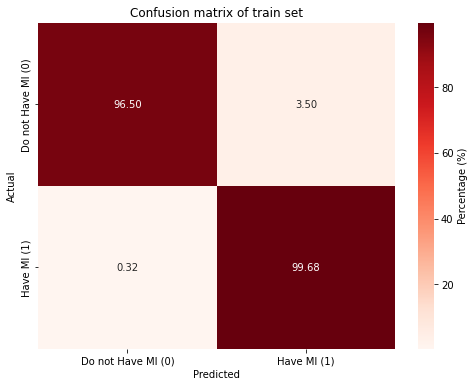

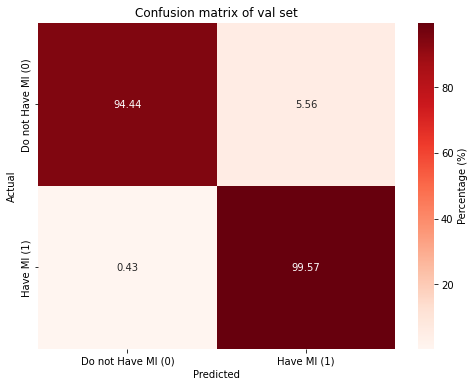

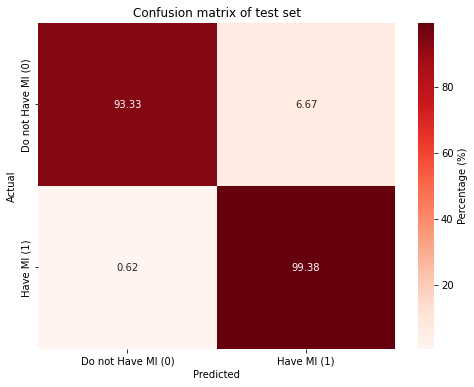

In [ ]:
for set_,loader_ in zip(['train','val','test'],[train_loader,val_loader,test_loader]):
    cm_plotter(model,loader_,optimal_threshold, set_)
    print('\n')

The model has performed exceptionally well, as it consistently predicts patients with Myocardial Infarction as having Myocardial Infarction across all the train, validation, and test sets. This is a highly encouraging outcome, as it suggests that if the model were to be deployed, it would be highly accurate in identifying patients with Myocardial Infarction, with a low risk of misclassification (< ~0.5%)

## Demonstration of prediction

Demonstrate how to predict the input from each set, and also some random generated input with does not satisfy the shape (1,1,187)

In [ ]:
map_dct = {0:'normal',
           1:'myocardial infarction'}

optimal_threshold = 0.46949878334999084

def predict(model, data, threshold = optimal_threshold,map_dct = map_dct):
    model.eval()
    with torch.no_grad():
        output = model(data)
        probs = F.sigmoid(output)
        preds = torch.where(probs > threshold, 1, 0)
        preds = map_dct[preds.item()]

    return probs.item(), preds

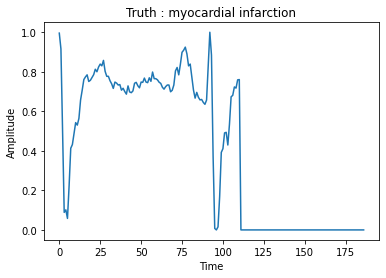

predict this as class myocardial infarction with probability 0.9999949932098389


In [ ]:
index = 0 #@param {type:"slider", min:0, max:2909, step:1}
set_ = val_set #@param ["train_set", "val_set", "test_set"] {type:"raw"}

def predict_on_set(index,set_ = set_, map_dct = map_dct):

    data = set_[index]

    # X
    X = data[0].to(device)

    # Y_t
    target = data[1].item()
    target = map_dct[target]

    plt.plot(X.cpu()[0])
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Truth : {target}")
    plt.show()

    # Y_pred
    prob, pred = predict(model,X.unsqueeze(0))

    if target == 'normal':
        print(f'predict this as class {pred} with probability {1-prob}')
    else:
        print(f'predict this as class {pred} with probability {prob}')

# Try predict
predict_on_set(index)



---



Next, we can predict on the generated data which may or may not have the same shape

In [ ]:
def preprocess(X,fix_seq_len = 187):
    """
    Fill to make the input tensor satisfy with tensor shape (1,1,187) bu padding or truncate (last)
    """
    seq_len = X.shape[2]

    if seq_len < fix_seq_len:
        diff = fix_seq_len - seq_len
        X = torch.nn.functional.pad(X, (0, diff)) #pad the sample

    elif seq_len > fix_seq_len:
        X = X[:, :, :fix_seq_len] # truncate-last on the sample
    
    assert X.shape == (1,1,187)
    return X

In [ ]:
import random

def predict_unknown(data=None):
    if data is None:
        random_len = random.randrange(1,187)
        data = torch.rand(1,1,random_len)

    processed_data = preprocess(data)
    processed_data = processed_data.to(device)

    plt.plot(processed_data.cpu()[0][0],color="red")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title(f"Truth : unknown")
    plt.show()

    prob, pred = predict(model,processed_data)
    if pred == 'normal':
        print(f'predict this as class {pred} with probability {1-prob}')
    else:
        print(f'predict this as class {pred} with probability {prob}')

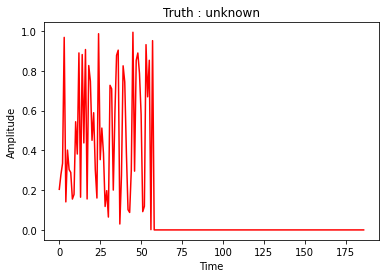

predict this as class myocardial infarction with probability 0.9999997615814209


In [ ]:
# Try random
# Always expect positive, sine it is unusual to have this fluctuate
predict_unknown()

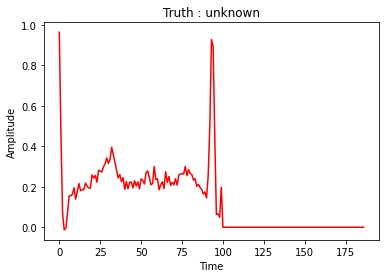

predict this as class myocardial infarction with probability 0.5156314373016357


In [ ]:
x = test_set[1][0]
x = x[:,:100] # random cut the first 100 timestep

std = 0.02
noise = torch.randn(x.shape) * std
noisy_x = x + noise

# Try on noisy real data
predict_unknown(noisy_x.unsqueeze(0))

# ⏭ Deployment

Integrating the trained model into a system that connects with a cardiac monitoring device can aid in the early detection and diagnosis of myocardial infarction. The model can quickly analyze electrocardiogram signals to determine if a patient is experiencing a heart attack, and provide early alerts for medical professionals to initiate timely interventions.

Before deployment in a clinical setting, the system will undergo rigorous review and testing by medical experts to ensure its accuracy and reliability. This approach can potentially reduce healthcare costs by minimizing the need for invasive procedures and hospitalizations, while also improving patient outcomes.

Overall, the deployment of this model has the potential to significantly enhance the efficiency of healthcare delivery by enabling early detection and diagnosis of myocardial infarction, leading to better health outcomes and potentially saving lives.





![](https://i.imgur.com/v3bsAbA.png)

This is my proposal for deploying the project in real-life, despite my limitations in obtaining the actual ECG heart signal. Instead, I plan to develop a Flask API server that can receive data from an ECG machine, and then notify the patient's caregiver, doctor, or nurse. Although I won't be able to perform preprocessing in real-time, I will assume that the data has already been preprocessed as outlined in the research paper (with the exception of zero-padding) which involves approximately 7 steps.


The Flask API is hosted here : https://ecg-heartbeat-ai.onrender.com



There are 2 ways to obtain the output given the heartbeat signal data: POST and GET.

Although POST is more efficient, but for simplicity, I am going to demonstrate using GET method

Suppose you have a heartbeat signal with 5 timesteps : [0.43,0.56,0.57,0.46,0.461], then to obtain the output via GET method will be the following

https://ecg-heartbeat-ai.onrender.com/predict_ar?beat_input=[0.43,0.56,0.57,0.46,0.461]

then you will expect the output in form of dictionary like

{'myocardial infarction' : 0.9993}

I have a real test case for this task, which the data is actually from the test set, you can check out here : https://github.com/saranpan/ECG-Heartbeat-classifier/blob/main/real_test_case_mi.txt, at the end of the data, you will the actual label of that